In [1]:
##### Automatically reload modules #####
%load_ext autoreload
%autoreload 2

# Import Modules

In [26]:
import os
import json
import yaml
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from omegaconf import OmegaConf
from matplotlib import gridspec
from test_tube import Experiment
from tqdm.auto import tqdm

##### Pytorch imports #####
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

##### Custom imports #####
from main import arg_parser
from utils import *
from models import NeuralNetwork
from train import train, test
import utils.io_dict_to_hdf5 as ioh5
np.set_printoptions(suppress=True)

##### Plotting settings ######
import matplotlib as mpl
sns.set_theme(context='talk', font='Arial', color_codes=True)
sns.set_style("white")
sns.set_context("talk")
mpl.rcParams.update({'font.size':         10,
                     'axes.linewidth':    2,
                     'xtick.major.size':  3,
                     'xtick.major.width': 2,
                     'ytick.major.size':  3,
                     'ytick.major.width': 2,
                     'axes.spines.right': False,
                     'axes.spines.top':   False,
                     'pdf.fonttype':      42,
                     'xtick.labelsize':   10,
                     'ytick.labelsize':   10,
                     'figure.facecolor': 'white'
                    })

##### Device settings ######
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


# Load Config file and argparser

In [27]:
args = arg_parser(jupyter=True)
save_dir = Path(args['save_dir'])
save_dir.mkdir(parents=True, exist_ok=True)
data_dir = Path('./data/{}/raw/'.format(args['dataset_type']))
exp_dir_name = args['dataset_type']
ModelID = 'Testing_{}'.format(args['dataset_type'])
version = args['version']


exp = Experiment(name='{}'.format(ModelID),
                    save_dir=save_dir / exp_dir_name, 
                    debug=False,
                    version=version)

save_model = exp.save_dir / exp.name / 'version_{}/media'.format(version)
fig_path = exp.save_dir / exp.name / 'version_{}/figures'.format(version)
fig_path.mkdir(parents=True, exist_ok=True)

config_path = Path('./conf/config.yaml')
config = OmegaConf.load(config_path)
config.args = {'dataset_type': args['dataset_type'], 'version': version, 'save_dir': save_dir, }
print(OmegaConf.to_yaml(config))


task: CompWorkflow
model:
  batch_size: 2048
  lr: 0.001
train:
  num_epochs: 5
  num_workers: 6
  save_summary_steps: 5
  checkpoint: ''
regularization:
  weight_decay: 0.0001
args:
  dataset_type: FashionMNIST
  version: testing
  save_dir: !!python/object/apply:pathlib.PosixPath
  - runs



In [ ]:
OmegaConf.save(config=config, f='./conf/config2.yaml')

# Basic Pytorch Example

In [ ]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [ ]:
# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=config.model.batch_size)
test_dataloader = DataLoader(test_data, batch_size=config.model.batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

In [ ]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

model = NeuralNetwork().to(device)
print(model)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=config.model.lr)

In [ ]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

# Plotting

In [44]:
ncol = 3
save_figs=False
fontsize=12
t = 0; dt = 500

def create_random_plot(fig_path,figsize=(6, 8),fontsize=12,save_figs=False,t=0,dt=500,nfig=0):
    ncol = 3
    fig = plt.figure(figsize=figsize) 
    gs = gridspec.GridSpec(nrows=4, ncols=3) 
    gs0 = gridspec.GridSpecFromSubplotSpec(1, ncol, subplot_spec=gs[0,:], wspace=.4,hspace=.5)
    gs1 = gridspec.GridSpecFromSubplotSpec(1, ncol, subplot_spec=gs[1,:], wspace=.2,hspace=.5)
    gs2 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[2:,:], wspace=.2,hspace=.5)

    x_all = []
    for k in range(ncol):
        ax = plt.subplot(gs0[0,k])
        plot_x = (k+1)*np.random.randn(1000,ncol)
        x_all.append(plot_x)
        ax.plot(plot_x[:,0], plot_x[:,1], '-k', lw=1)
        ax.set_xlabel("$x_1$",fontsize=fontsize)
        ax.set_ylabel("$x_2$",fontsize=fontsize)
        ax.set_xticks([-1,0,1])
        ax.set_xticklabels([-1,0,1])
        ax.set_yticks([-1,0,1])
        ax.set_yticklabels([-1,0,1])
        ax.set_title(f'Latent States {k+1}' '\n' r'$\tau=${}'.format(k),fontsize=fontsize)
        ax.set_aspect('equal', 'box')
        
        ax = plt.subplot(gs1[0,k])
        ax.acorr(plot_x[:,k],maxlags=100,usevlines=True,linestyle='-',color='k',lw=2)
        ax.set_xlabel("Lag",fontsize=fontsize)
        ax.set_yticks([0,1])
        ax.set_ylim(0,1)
        if k == 0:
            ax.set_ylabel("Autocorrelation",fontsize=fontsize)
        elif k == ncol-1:
            ax.set_yticks([])
    x_all = np.concatenate(x_all,axis=1)
    ax = plt.subplot(gs2[0])
    for n in range(x_all.shape[-1]):
        ax.plot(x_all[t:t+dt,n]/np.max(np.abs(x_all[t:t+dt,n])) + 2*n,'-k')
    ax.set_ylabel("Latent States",fontsize=fontsize)
    ax.set_xticks([])
    ax.set_yticks(np.arange(0,2*x_all.shape[-1],2))
    ax.set_yticklabels(np.arange(1,x_all.shape[-1]+1))

    plt.tight_layout()

    if save_figs:
        fig.savefig(fig_path/'{}_RandomPlot.png'.format(nfig))
        nfig = nfig+1

    return nfig, fig


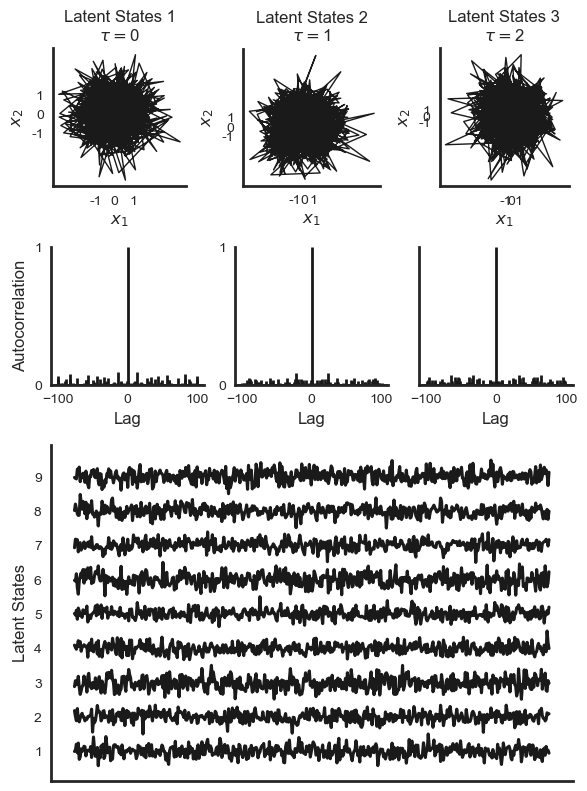

In [45]:
nfig,fig = create_random_plot(fig_path,config,figsize=(6, 8),fontsize=12,save_figs=False,t=0,dt=500,nfig=0)

In [51]:
fig_path.absolute()

PosixPath('/home/eabe/Research/MyRepos/computing_tutorial/runs/FashionMNIST/Testing_FashionMNIST/version_testing/figures')